# Practical Time Series Analysis Lecture 3
# Statistical Forecasting Methods 
- Exponential Smoothing Methods 
- AR(p) and MA(q) processes
- ARIMA, SARIMA models

## Import & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.datasets import get_rdataset
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [2]:
def split_data(df, test_prop= 0.1):
    """
    Splits the dataframe into train and test sets based on the specified test size
    Test size is the proportion of the dataset to include in the test split
    """
    test_size = int(test_prop * len(df))
    
    train, test = df[:-test_size], df[-test_size:]
    print('train shape:', train.shape)
    print('test shape:', test.shape)
    return train, test, test_size

In [3]:
def test_stationarity(ts):
    result_ADF = adfuller(ts) 
    p_value_ADF = result_ADF[1]
    print(f'ADF Statistic: {result_ADF[0]:.3f}')
    print(f'ADF p-value: {p_value_ADF:.3f}')
    if p_value_ADF < 0.05:
        print('p-value < 0.05: the series is stationary')
    else:
        print('p-value > 0.05: the series is non-stationary')
    print('--------------------------------')
    
    result_KPSS = kpss(ts)
    p_value_KPSS = result_KPSS[1]
    print(f'KPSS Statistic: {result_KPSS[0]:.3f}')
    print(f'KPSS p-value: {p_value_KPSS:.3f}')
    if p_value_KPSS > 0.05:
        print('p-value > 0.05: the series is stationary')
    else:
        print('p-value < 0.05: the series is non-stationary')

## Load Data Sets

In [4]:
from statsmodels.datasets import co2, get_rdataset

# Mauna Loa Weekly Atmospheric CO2 Data
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()

#Monthly Airline Passenger Numbers 1949-1960, in thousands
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)

# load the file of stocks closing_price.csv to df from the folder 'Data_sets' located in the local project folder
closing_price = pd.read_csv('../Data_sets/closing_price.csv', index_col='Date', parse_dates=True)

btc_data = yf.download('BTC-USD', start='2010-01-01', end='2025-12-31')
# Extract the 'Close' price
btc_close = btc_data['Close']

[*********************100%***********************]  1 of 1 completed


In [5]:
# Load the Sunspot dataset
sunspot_data = get_rdataset("sunspot.year").data
# Set the index by the 'time' column
sunspot_data.set_index('time', inplace=True)
# set index to be a datetime type 
sunspot_data.index = pd.to_datetime(sunspot_data.index, format='%Y')


## Exponential Smothing


### Implementing Single Exponential Smoothing

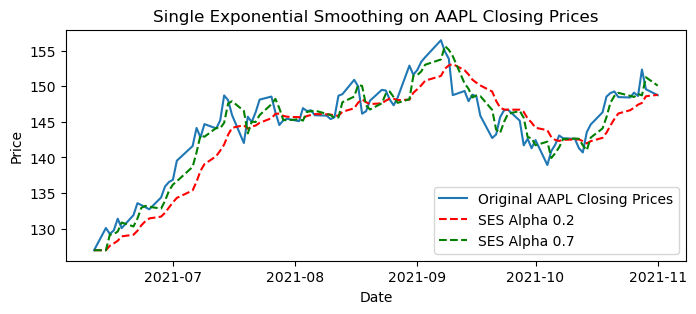

In [6]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# cut the last 100 days of the AAPL closing price
AAPL = closing_price['AAPL'][-100:]

# Apply Single Exponential Smoothing
alpha = 0.2  # Smoothing factor
model = SimpleExpSmoothing(AAPL).fit(smoothing_level=alpha)
AAPL_smoothed_02 = model.fittedvalues # Get the smoothed series

alpha = 0.7  # Smoothing factor
model = SimpleExpSmoothing(AAPL).fit(smoothing_level=alpha)
AAPL_smoothed_07 = model.fittedvalues # Get the smoothed series

# Plot the original and smoothed series
plt.figure(figsize=(8, 3))
plt.plot(AAPL, label='Original AAPL Closing Prices')
plt.plot(AAPL_smoothed_02, label='SES Alpha 0.2', color='red', linestyle='--')
plt.plot(AAPL_smoothed_07, label='SES Alpha 0.7', color='green', linestyle='--')
plt.title('Single Exponential Smoothing on AAPL Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


### Forecasting with double and triple exponential smoothing


#### Exponential smoothing on the CO2 dataset with trend and seasonality addative model

train shape: (850, 1)
test shape: (150, 1)


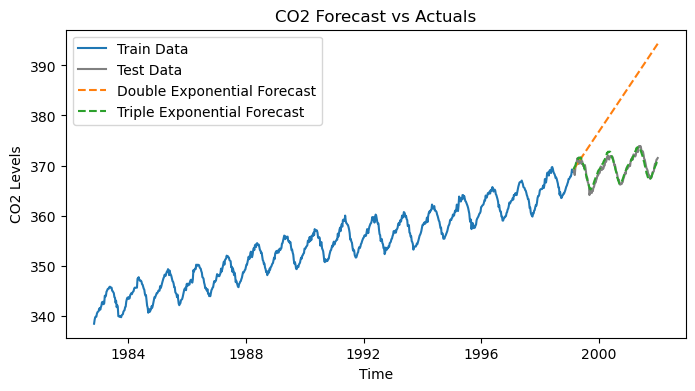

Level: 0.4216
Trend: 0.0078
Seasonal: 0.0000
Double Exponential Smoothing RMSE: 14.10
Triple Exponential Smoothing RMSE: 0.68


In [7]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Use the last 1000 observations for the analysis
co2_df_short = co2_df[-1000:] # Use the last 1000 observations for the analysis

# Split the data into train and test sets
train, test, test_size = split_data(co2_df_short, test_prop=0.15)

# Double Exponential Smoothing
# Assuming an additive trend might be appropriate; adjust based on data analysis
model_double = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=False)
ES_double = model_double.fit()
forecast_double = ES_double.forecast(steps=test_size)

# Triple Exponential Smoothing (Holt-Winters)
# Assuming addative trend and seasonality of 52 weeks per year
model_triple = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=52, damped_trend=True)
ES_triple = model_triple.fit()
forecast_triple = ES_triple.forecast(steps=test_size)

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data', color='gray')
plt.plot(test.index, forecast_double, label='Double Exponential Forecast', linestyle='--')
plt.plot(test.index, forecast_triple, label='Triple Exponential Forecast', linestyle='--')
plt.title('CO2 Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()

# Get the fitted level, trand and seasonal parameters
params = ES_triple.params['smoothing_level'], ES_triple.params['smoothing_trend'], ES_triple.params['smoothing_seasonal']
# print the parameters
print(f'Level: {params[0]:.4f}')
print(f'Trend: {params[1]:.4f}')
print(f'Seasonal: {params[2]:.4f}')

# Calculate and print RMSE
rmse_double = np.sqrt(mean_squared_error(test, forecast_double))
rmse_triple = np.sqrt(mean_squared_error(test, forecast_triple))
print(f'Double Exponential Smoothing RMSE: {rmse_double:.2f}')
print(f'Triple Exponential Smoothing RMSE: {rmse_triple:.2f}')

#### Exponential smoothing on the air_passengers dataset with trend and seasonality multiplicative model

train shape: (116, 1)
test shape: (28, 1)


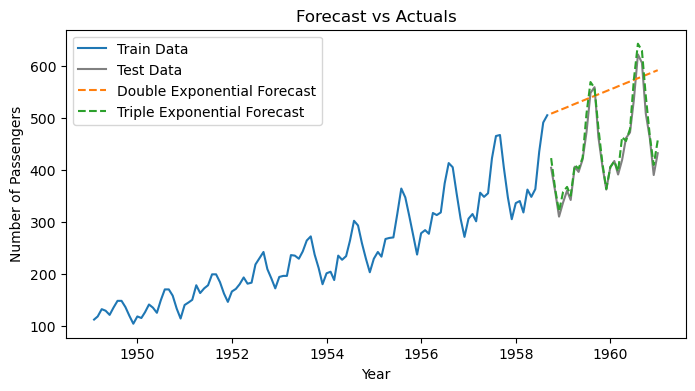

Level: 0.3650
Trend: 0.0000
Seasonal: 0.6350
Double Exponential Smoothing RMSE: 131.22
Triple Exponential Smoothing RMSE: 18.71


In [8]:
# Splitting the data into train and test sets with last 40 months as test set
train, test, test_size = split_data(airp_df, test_prop=0.2)


# Double Exponential Smoothing
model_double = ExponentialSmoothing(train, trend='add', seasonal=None)
ES_double = model_double.fit()
forecast_double = ES_double.forecast(steps=test_size)

# Triple Exponential Smoothing (Holt-Winters)
model_triple = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=12, damped_trend=True)
ES_triple = model_triple.fit()
forecast_triple = ES_triple.forecast(steps=test_size)

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data', color='gray')
plt.plot(test.index, forecast_double, label='Double Exponential Forecast', linestyle='--')
plt.plot(test.index, forecast_triple, label='Triple Exponential Forecast', linestyle='--')
plt.title('Forecast vs Actuals')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Get the fitted level, trand and seasonal parameters
params = ES_triple.params['smoothing_level'], ES_triple.params['smoothing_trend'], ES_triple.params['smoothing_seasonal']
# print the parameters
print(f'Level: {params[0]:.4f}')
print(f'Trend: {params[1]:.4f}')
print(f'Seasonal: {params[2]:.4f}')

# Calculate and print RMSE
rmse_double = np.sqrt(mean_squared_error(test, forecast_double))
rmse_triple = np.sqrt(mean_squared_error(test, forecast_triple))
print(f'Double Exponential Smoothing RMSE: {rmse_double:.2f}')
print(f'Triple Exponential Smoothing RMSE: {rmse_triple:.2f}')

#### Explore exponential smothing method on a complex time series

train shape: (240,)
test shape: (60,)


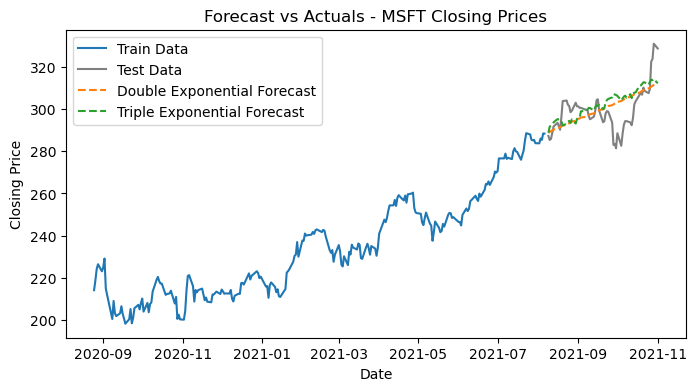

Double Exponential Smoothing RMSE: 9.10
Triple Exponential Smoothing RMSE: 9.82


In [9]:
#  cut the closing_price['MSFT'] for the last 200 days
MSFT = closing_price['MSFT'][-300:]

# Splitting the data
train, test, test_size = split_data(MSFT, test_prop=0.2)

# Double Exponential Smoothing
model_double = ExponentialSmoothing(train, trend='mul', seasonal=None)
ES_double = model_double.fit()
forecast_double = ES_double.forecast(steps=test_size)

# Triple Exponential Smoothing (Holt-Winters)
model_triple = ExponentialSmoothing(train, trend='mul', seasonal='add', seasonal_periods=30)
ES_triple = model_triple.fit()
forecast_triple = ES_triple.forecast(steps=test_size)

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data', color='gray')
plt.plot(test.index, forecast_double, label='Double Exponential Forecast', linestyle='--')
plt.plot(test.index, forecast_triple, label='Triple Exponential Forecast', linestyle='--')
plt.title('Forecast vs Actuals - MSFT Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Calculate and print RMSE
rmse_double = np.sqrt(mean_squared_error(test, forecast_double))
rmse_triple = np.sqrt(mean_squared_error(test, forecast_triple))
print(f'Double Exponential Smoothing RMSE: {rmse_double:.2f}')
print(f'Triple Exponential Smoothing RMSE: {rmse_triple:.2f}')

## Autoregressive (AR) & Moving Average (MA) Process

### Simulating basic stationary time series processes

In [ ]:
# --- Reproducibility & settings ---
np.random.seed(42)
n = 100  # number of observations in the time series
phi = 0.8    # AR(1) coefficient
sigma = 1.0
theta = 0.8  # MA(1) coefficient

# --- Simulate processes ---
# White noise
wn = np.random.normal(0, 1, n)


# AR(1): X_t = phi * X_{t-1} + e_t
ar = np.zeros(n)
for t in range(1, n):
    ar[t] = (phi * ar[t-1]) + (np.random.normal(0, 1)) # + (phi * ar[t-2]) 


# MA(1): X_t = e_t + theta * e_{t-1}
eps = np.random.normal(0, 1, n)
ma = np.zeros(n)
for t in range(1, n):
    ma[t] = eps[t] + theta * eps[t-1] # + theta * eps[t-2]

# --- Plot time series ---
fig, axes = plt.subplots(3, 1, figsize=(8, 7), sharex=True)
axes[0].plot(wn, marker='o', linestyle='-', color='black')
axes[0].set_title("White Noise (Stationary, No Autocorrelation)")
axes[0].set_ylabel("Value")

axes[1].plot(ar, marker='o', linestyle='-', color='tab:blue')
axes[1].set_title("AR Process (Stationary, Persistent Autocorrelation)")
axes[1].set_ylabel("Value")

axes[2].plot(ma, marker='o', linestyle='-', color='tab:orange')
axes[2].set_title("MA Process (Stationary, Short-lived Autocorrelation)")
axes[2].set_ylabel("Value")
axes[2].set_xlabel("Time")

plt.tight_layout()
plt.show()

#### Plot ACF / PACF to highlight differences 
- Determine the order of AR-p and MA-q

In [ ]:
# --- Plot ACFs ---
fig_acf, axes_acf = plt.subplots(3, 1, figsize=(9, 9))
plot_acf(wn, lags=10, ax=axes_acf[0], zero=False)
axes_acf[0].set_title("ACF: White Noise (no spikes beyond lag 0)")

plot_acf(ar, lags=10, ax=axes_acf[1], zero=False)
axes_acf[1].set_title("ACF: AR (gradual/exponential decay)")

plot_acf(ma, lags=10, ax=axes_acf[2], zero=False)
axes_acf[2].set_title("ACF: MA (cutoff after lag q)")

plt.tight_layout()
plt.show()

In [ ]:
# --- Plot PACFs ---
fig_pacf, axes_pacf = plt.subplots(3, 1, figsize=(9, 9))

plot_pacf(wn, lags=10, ax=axes_pacf[0], zero=False)
axes_pacf[0].set_title("PACF: White Noise (no spikes beyond lag 0)")

plot_pacf(ar, lags=10, ax=axes_pacf[1], zero=False)
axes_pacf[1].set_title("PACF: AR (cutoff after lag p)")

plot_pacf(ma, lags=10, ax=axes_pacf[2], zero=False)
axes_pacf[2].set_title("PACF: MA ")

plt.tight_layout()
plt.show()



## Fit AR model

### Explore Datasets & Check for Stationarity

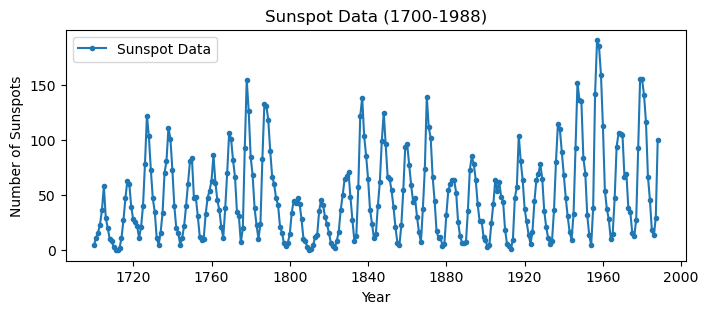

ADF Statistic: -2.384
ADF p-value: 0.146
p-value > 0.05: the series is non-stationary
--------------------------------
KPSS Statistic: 0.530
KPSS p-value: 0.035
p-value < 0.05: the series is non-stationary


<Figure size 700x200 with 0 Axes>

In [41]:
# Plot the Sunspot data
plt.figure(figsize=(8,3))
plt.plot(sunspot_data.index, sunspot_data['value'], marker = '.', label='Sunspot Data')
plt.title('Sunspot Data (1700-1988)')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.show()

# Plot the closing_price dataframe
plt.figure(figsize=(7, 2))

test_stationarity(sunspot_data['value'])

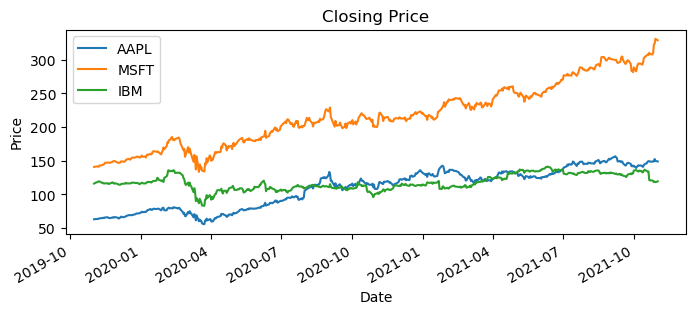

ADF Statistic: -2.397
ADF p-value: 0.142
p-value > 0.05: the series is non-stationary
--------------------------------
KPSS Statistic: 1.861
KPSS p-value: 0.010
p-value < 0.05: the series is non-stationary


In [12]:
closing_price.plot(title='Closing Price', figsize=(8, 3))
plt.title('Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

test_stationarity(closing_price['IBM'])

#### Apply differencing to enforce stationarity 


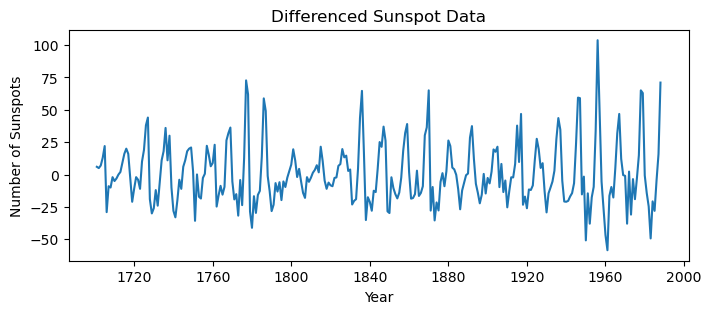

sunspot_diff
ADF Statistic: -14.076
ADF p-value: 0.000
p-value < 0.05: the series is stationary
--------------------------------
KPSS Statistic: 0.008
KPSS p-value: 0.100
p-value > 0.05: the series is stationary


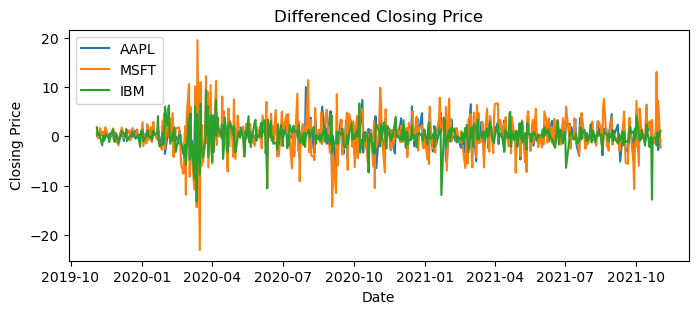

closing_price_diff
ADF Statistic: -25.383
ADF p-value: 0.000
p-value < 0.05: the series is stationary
--------------------------------
KPSS Statistic: 0.052
KPSS p-value: 0.100
p-value > 0.05: the series is stationary


In [13]:
# Difference the sunspot data
sunspot_diff = sunspot_data['value'].diff().dropna()

# Difference the closing_price dataset
closing_price_diff = closing_price.diff().dropna()

# plot the sunspot_diff 
plt.figure(figsize=(8, 3))
plt.plot(sunspot_diff)
plt.title('Differenced Sunspot Data')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.show()

print('sunspot_diff')
test_stationarity(sunspot_diff)

# plot the closing_price_diff with legend to each column
plt.figure(figsize=(8, 3))
plt.plot(closing_price_diff)
plt.title('Differenced Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(closing_price_diff.columns)
plt.show()

print('closing_price_diff')
test_stationarity(closing_price_diff['AAPL'])


#### Autocorrelation (ACF) and Partial Autocorrelation (PACF) Analysis
If the PACF plot shows a sharp cut-off, consider an AR model.
If the ACF plot shows a sharp cut-off, consider an MA model.
Model Order: The cut-off point in the ACF or PACF plots indicates the order (p for AR, q for MA).

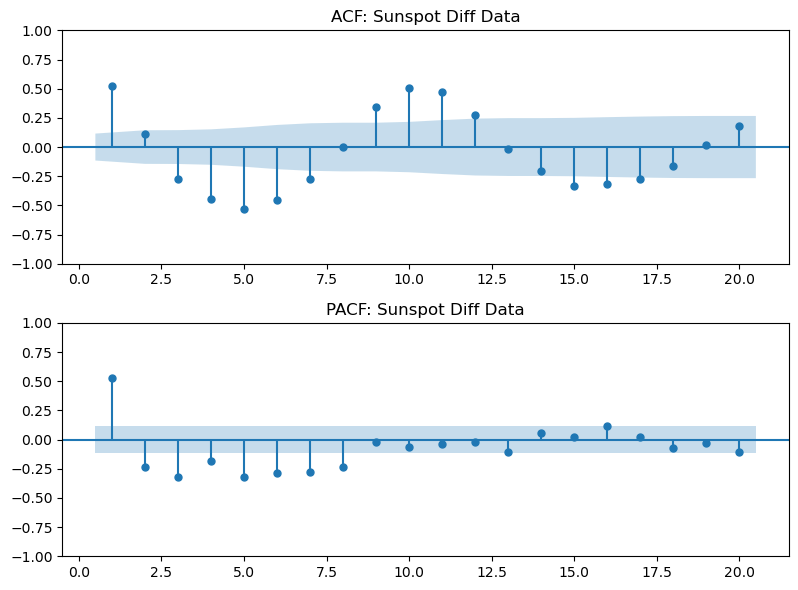

In [14]:
# --- Plot ACF / PACF ---
fig_acf, axes_acf = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(sunspot_diff, lags=20, ax=axes_acf[0], zero=False)
axes_acf[0].set_title("ACF: Sunspot Diff Data")
plot_pacf(sunspot_diff, lags=20, ax=axes_acf[1], zero=False)
axes_acf[1].set_title("PACF: Sunspot Diff Data")

plt.tight_layout()
plt.show()

- Sunspot shows ACF of a cyclic patern and PACF significant spikes up to 8 lags
- BTC Log Diff has no apperant Autocorrelation therfore is not suitable for AR modeling

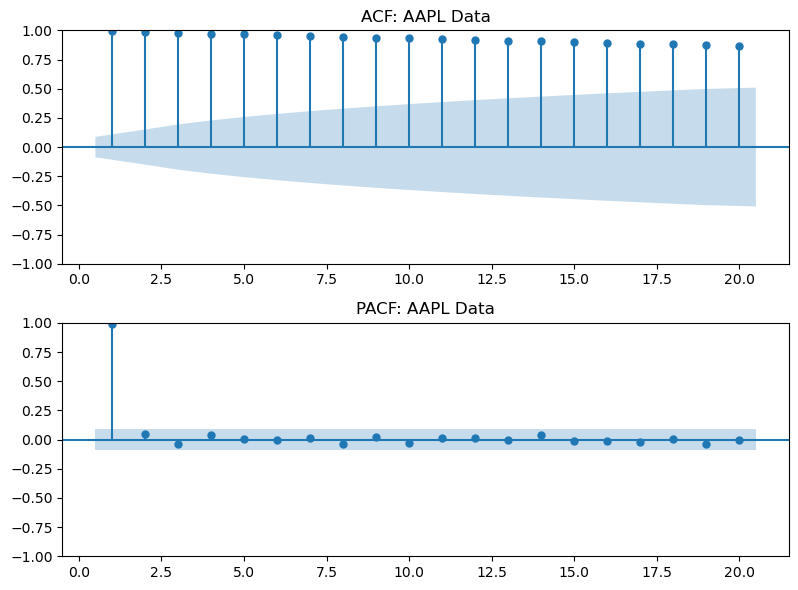

In [15]:
# --- Plot ACF / PACF ---
fig_acf, axes_acf = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(closing_price['AAPL'], lags=20, ax=axes_acf[0], zero=False)
axes_acf[0].set_title("ACF: AAPL Data")
plot_pacf(closing_price['AAPL'], lags=20, ax=axes_acf[1], zero=False)
axes_acf[1].set_title("PACF: AAPL Data")

plt.tight_layout()
plt.show()

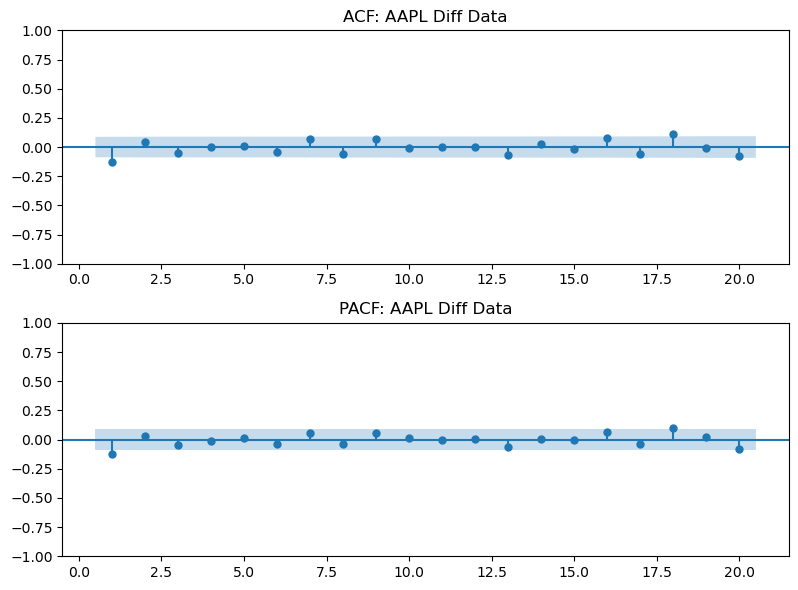

In [16]:
# --- Plot ACF / PACF ---
fig_acf, axes_acf = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(closing_price_diff['AAPL'], lags=20, ax=axes_acf[0], zero=False)
axes_acf[0].set_title("ACF: AAPL Diff Data")
plot_pacf(closing_price_diff['AAPL'], lags=20, ax=axes_acf[1], zero=False)
axes_acf[1].set_title("PACF: AAPL Diff Data")

plt.tight_layout()
plt.show()

### Fit the AR Model and Evaluate results
 Use the AutoReg function for pure AR models 

In [17]:
# Simple AR(1) model with AutoReg
from statsmodels.tsa.ar_model import AutoReg

def fit_ar_model(ts_data, lags, trend='ct'):
    # 1. Fit AR model
    model = AutoReg(ts_data, lags=lags, trend=trend)
    results = model.fit()
    print(results.summary())

    # 2. Claculate the RMSE
    y = ts_data.loc[results.fittedvalues.index]
    rmse = np.sqrt(mean_squared_error(y, results.fittedvalues))
    print(f"RMSE: {rmse:.3f}")

    # 3.Fitted vs actual
    plt.figure(figsize=(8,4))
    plt.plot(ts_data.index, ts_data, label='Actual', alpha=0.7)
    plt.plot(results.fittedvalues.index, results.fittedvalues, label='Fitted', alpha=0.7)
    plt.text(0.1, 0.95, f'RMSE: {rmse:.3f}', transform=plt.gca().transAxes, fontsize=12, ha='center', va='center')
    plt.title('AR(1) Model: Fitted vs Actual')
    plt.legend()
    plt.show()

    # 4. Residual analysis
    residuals = results.resid

    fig, axes = plt.subplots(2, 1, figsize=(8, 6))

    # Plot residuals
    axes[0].plot(residuals)
    axes[0].set_title('AR(1) Residuals')
    axes[0].set_ylabel('Residuals')

    # Plot ACF of residuals
    plot_acf(residuals, lags=10, zero=False, ax=axes[1])
    axes[1].set_title('ACF of Residuals')

    plt.tight_layout()
    plt.show()

                            AutoReg Model Results                             
Dep. Variable:                   AAPL   No. Observations:                  504
Model:                     AutoReg(1)   Log Likelihood               -1122.232
Method:               Conditional MLE   S.D. of innovations              2.253
Date:                Sun, 28 Sep 2025   AIC                           2252.465
Time:                        12:46:40   BIC                           2269.347
Sample:                             1   HQIC                          2259.088
                                  504                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9644      0.689      2.850      0.004       0.613       3.316
trend          0.0052      0.002      2.428      0.015       0.001       0.009
AAPL.L1        0.9717      0.011     91.086      0.0

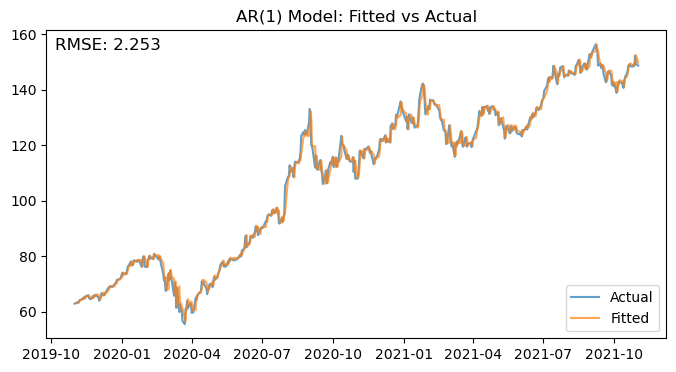

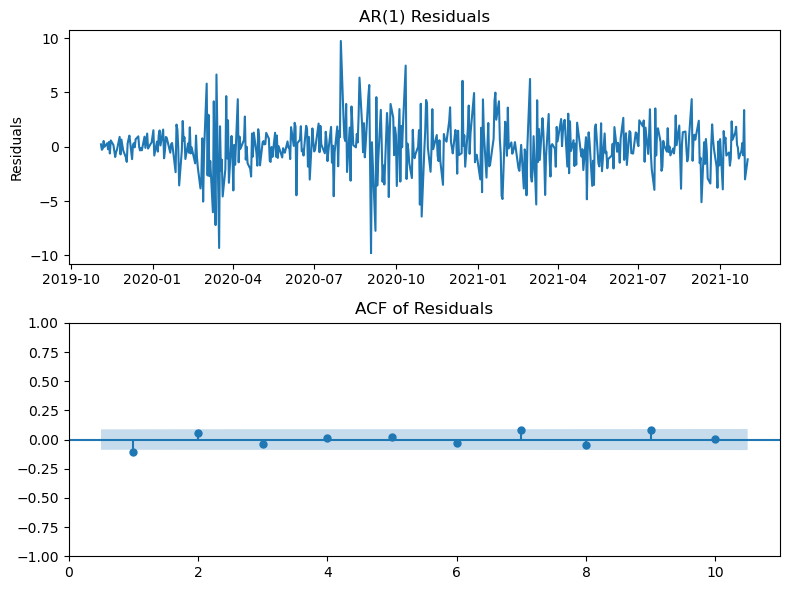

In [18]:
fit_ar_model(ts_data= closing_price['AAPL'], lags = 1, trend='ct')

                            AutoReg Model Results                             
Dep. Variable:                  value   No. Observations:                  288
Model:                     AutoReg(8)   Log Likelihood               -1156.751
Method:               Conditional MLE   S.D. of innovations             15.064
Date:                Sun, 28 Sep 2025   AIC                           2335.503
Time:                        12:47:08   BIC                           2375.486
Sample:                    01-01-1709   HQIC                          2351.540
                         - 01-01-1988                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2464      1.884      0.131      0.896      -3.445       3.938
trend          0.0026      0.011      0.231      0.818      -0.019       0.024
value.L1       0.2204      0.058      3.778      0.0

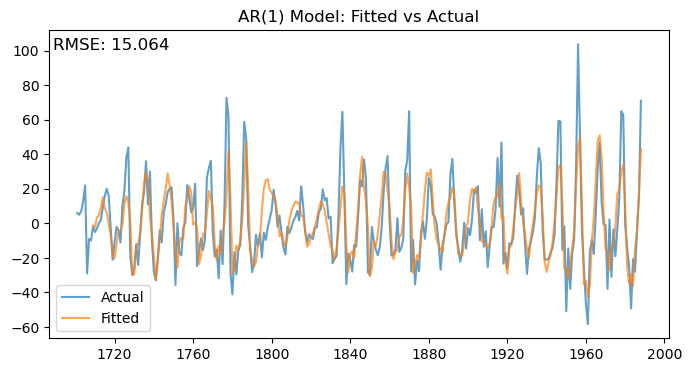

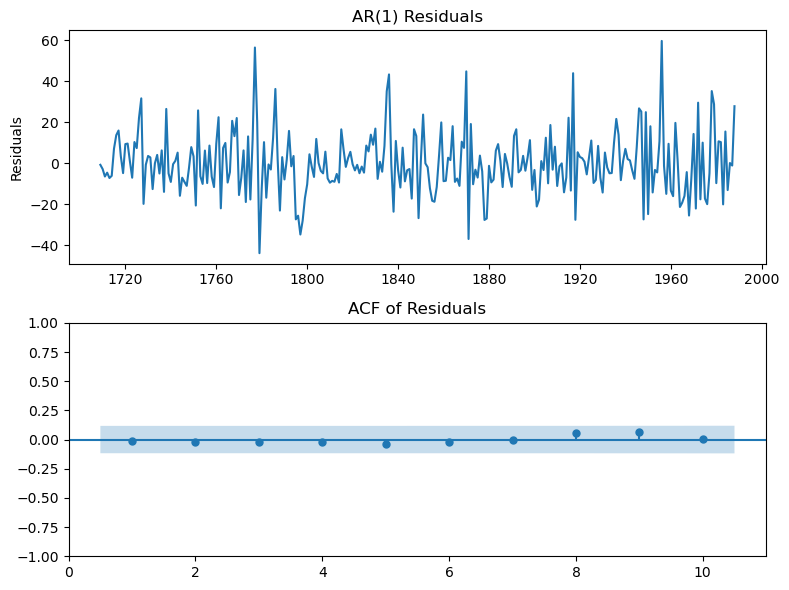

In [19]:
fit_ar_model(ts_data= sunspot_diff, lags = 8, trend='ct')

### Predict multistep future values

train shape: (260,)
test shape: (28,)


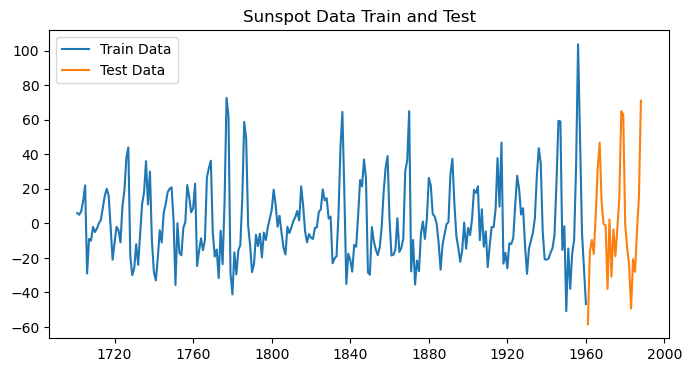

In [21]:
train_sunspot, test_sunspot, test_size = split_data(sunspot_diff, test_prop=0.1)
#plot the train and test data
plt.figure(figsize=(8, 4))
plt.plot(train_sunspot.index, train_sunspot, label='Train Data')
plt.plot(test_sunspot.index, test_sunspot, label='Test Data')
plt.title('Sunspot Data Train and Test')
plt.legend()
plt.show()

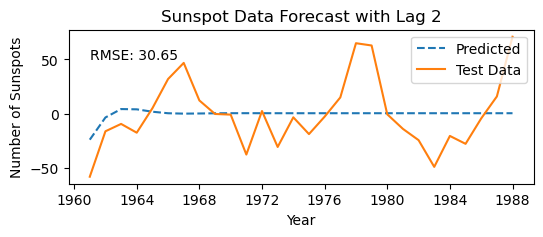

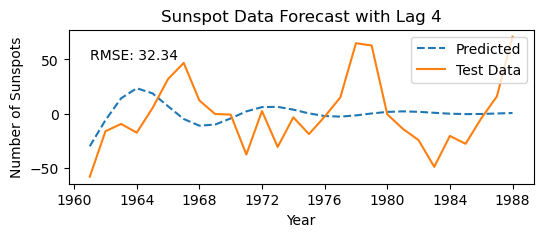

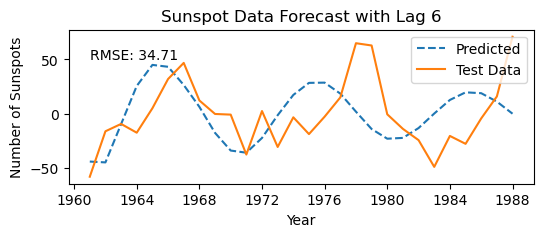

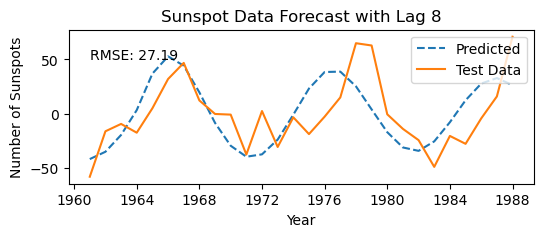

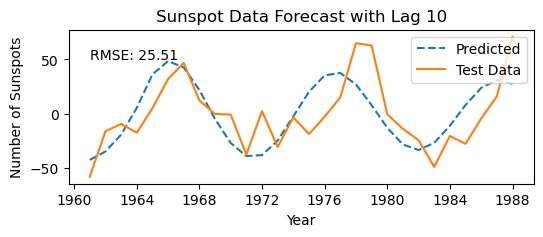

                            AutoReg Model Results                             
Dep. Variable:                  value   No. Observations:                  260
Model:                    AutoReg(10)   Log Likelihood               -1026.488
Method:               Conditional MLE   S.D. of innovations             14.688
Date:                Sun, 28 Sep 2025   AIC                           2076.976
Time:                        16:17:55   BIC                           2119.234
Sample:                    01-01-1711   HQIC                          2093.984
                         - 01-01-1960                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7913      0.933      0.848      0.396      -1.037       2.620
value.L1       0.2227      0.063      3.522      0.000       0.099       0.347
value.L2      -0.2353      0.065     -3.628      0.0

In [22]:

# creat loop to find the best lag and plot the test data and the predicted data
for i in range(2, 11, 2):
    model = AutoReg(train_sunspot, lags=i)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train_sunspot), end=len(train_sunspot)+len(test_sunspot)-1)
    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_sunspot, predictions))

    plt.figure(figsize=(6, 2))
    plt.plot(test_sunspot.index, predictions, label='Predicted', linestyle='--')
    plt.plot(test_sunspot.index, test_sunspot, label='Test Data')  
    plt.title(f'Sunspot Data Forecast with Lag {i}')
    plt.xlabel('Year')
    plt.ylabel('Number of Sunspots')
    plt.text(test_sunspot.index[0], 50, f'RMSE: {rmse:.2f}')
    plt.legend()
    plt.show()

print(model_fit.summary())

## ARIMA model implementation

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

### Supporting function

In [113]:
# a function to plot 3 figures: the original data, ACF and PACF on a subplot
def plot_data_acf_pacf(data, lags=40):
    fig, ax = plt.subplots(3, 1, figsize=(8, 7))
    ax[0].plot(data)
    ax[0].set_title('Time Series Data')
    plot_acf(data, lags=lags, ax=ax[1], zero=False)
    plot_pacf(data, lags=lags, ax=ax[2], zero=False) 
    plt.tight_layout()   
    plt.show()

def evaluate_arima_model(model, train, lags=10):
    """
    Evaluate ARIMA model fit on training data.
    Plots: Fitted vs Actual, Residuals, and ACF of Residuals.
    Prints RMSE.
    """
    # Calculate RMSE
    y = train.loc[model.fittedvalues.index]
    rmse = np.sqrt(mean_squared_error(y, model.fittedvalues))
    print(f"RMSE: {rmse:.3f}")

    residuals = model.resid
    p, d, q = model.model.order

    fig, axes = plt.subplots(3, 1, figsize=(9, 8))

    # Plot fitted vs actual
    axes[0].plot(train.index, train, label='Actual', marker = '.')
    axes[0].plot(train.index, model.fittedvalues, label='Fitted', marker = '.')
    axes[0].text(0.1, 0.95, f'RMSE: {rmse:.3f}', transform=axes[0].transAxes, fontsize=12, ha='left', va='top')
    axes[0].set_title(f'ARIMA ({p},{d},{q}) Model: Fitted vs Actual')
    axes[0].legend()

    # Plot residuals
    axes[1].plot(residuals, marker = '.')
    axes[1].set_title('Residuals')
    axes[1].set_ylabel('Residuals')

    # Plot ACF of residuals
    plot_acf(residuals, lags=lags, zero=False, ax=axes[2])
    axes[2].set_title('ACF of Residuals')

    plt.tight_layout()
    plt.show()

# function to plot the forecast vs actuals (test) values and calculate the RMSE
def plot_forecast_vs_actuals(train, test, forecast): 
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f'ARIMA RMSE: {rmse:.2f}')

    # Plot the results
    plt.figure(figsize=(8, 4))
    plt.plot(train.index, train, label='Train Data')
    plt.plot(test.index, test, label='Test Data', color='gray')
    plt.plot(test.index, forecast, label='ARIMA Forecast', linestyle='--')
    # Place RMSE annotation in axes coordinates, not data coordinates, for robustness
    plt.gca().text(0.05, 0.05, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, fontsize=12, ha='left', va='top')
    plt.title('Forecast vs Actuals')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Simulate ARMA data

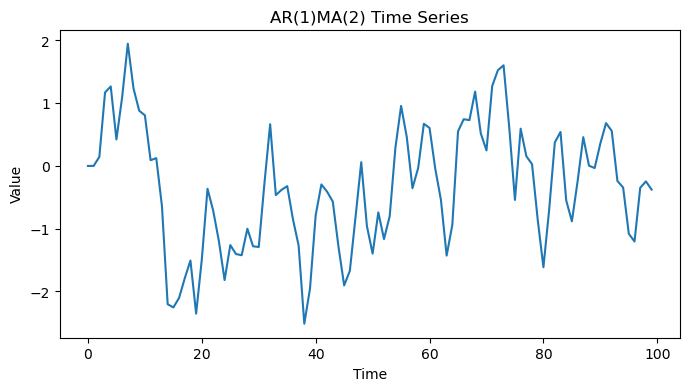

In [24]:
# Simulate AR(1)MA(2) process: X_t = phi*X_{t-1} + e_t + theta1*e_{t-1} + theta2*e_{t-2}
np.random.seed(42)
n = 100  # number of observations
phi = 0.8    # AR(1) coefficient
theta1 = 0.8 # MA(1) coefficient
theta2 = -0.5 # MA(2) coefficient
sigma = 0.5  # standard deviation of noise

# Generate white noise
e = np.random.normal(0, sigma, n)

# Initialize the series
arima = np.zeros(n)

# Simulate AR(1)MA(2)
for t in range(2, n):
    arima[t] = (
        phi * arima[t-1] +
        e[t] +
        theta1 * e[t-1] +
        theta2 * e[t-2]
    )
# insert to df
arima = pd.DataFrame(arima, index=range(n))
# plot the arima time series
plt.figure(figsize=(8, 4))
plt.plot(arima)
plt.title('AR(1)MA(2) Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


### **ARMA simulated Data**

#### Explore Time Series data 

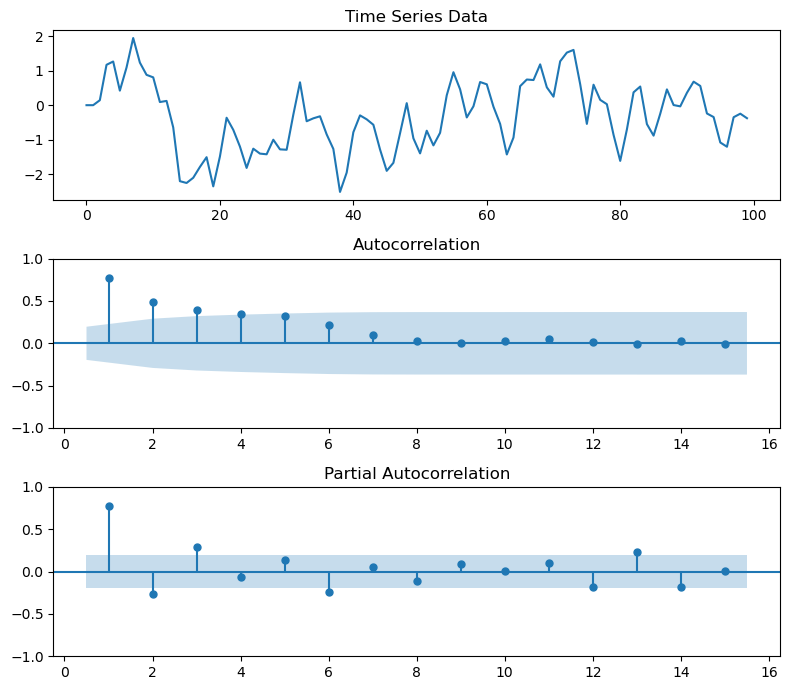

ADF Statistic: -3.011
ADF p-value: 0.034
p-value < 0.05: the series is stationary
--------------------------------
KPSS Statistic: 0.245
KPSS p-value: 0.100
p-value > 0.05: the series is stationary


In [35]:
## Select the Data
ts_data = arima

plot_data_acf_pacf(ts_data, lags=15)
test_stationarity(ts_data)

#### Modeling ARIMA
- Select the orders of p & q by the ACF PACF

##### Fit Model & Evaluate

train shape: (130, 1)
test shape: (14, 1)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  130
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -621.375
Date:                Mon, 29 Sep 2025   AIC                           1252.750
Time:                        11:19:03   BIC                           1267.088
Sample:                    01-31-1949   HQIC                          1258.576
                         - 10-31-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        260.6339     58.321      4.469      0.000     146.327     374.941
ar.L1          0.9575      0.029     32.743      0.000       0.900       1.015
ma.L1     

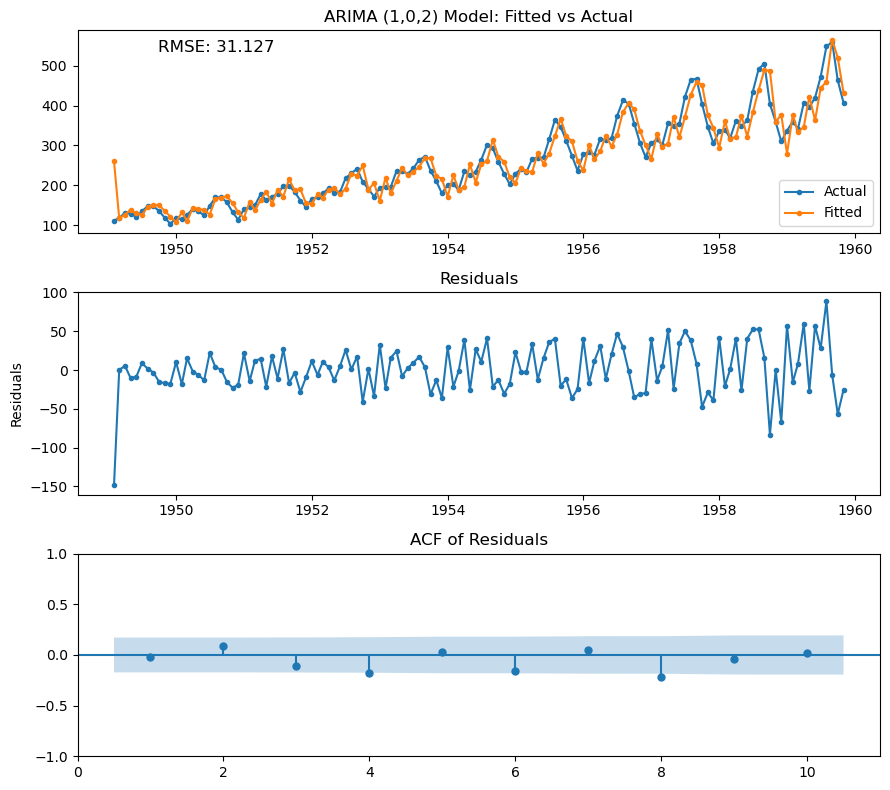

In [118]:
# split the data into train and test, with last 30 months as test set
train, test , test_size = split_data(ts_data, test_prop=0.1)

p = 1 # AR order
d = 0 # Differencing order
q = 2 # MA order

# fit the model to the train data
model = ARIMA(train,order = (p,d,q)).fit()

print(model.summary())

evaluate_arima_model(model, train, lags=10)


##### Predict Multistep Future Valvues

ARIMA RMSE: 0.54


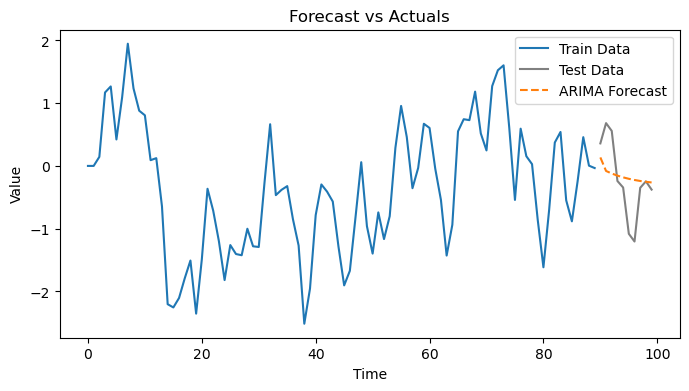

In [40]:
# Forecast the test data
forecast = model.forecast(steps=test_size)
plot_forecast_vs_actuals(train, test, forecast)


### **Sunspot Data**

#### Explore Time Series data 

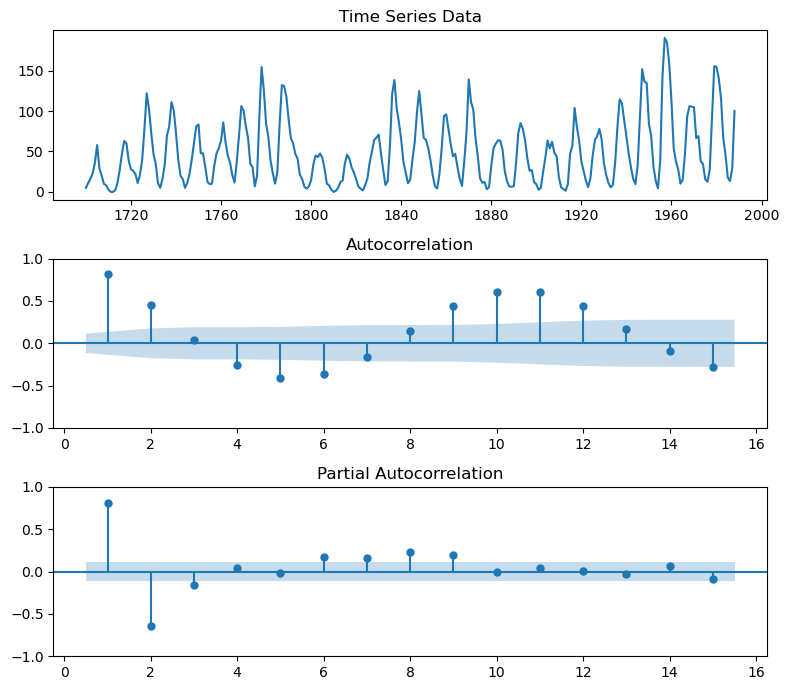

ADF Statistic: -2.384
ADF p-value: 0.146
p-value > 0.05: the series is non-stationary
--------------------------------
KPSS Statistic: 0.530
KPSS p-value: 0.035
p-value < 0.05: the series is non-stationary


In [ ]:
## Select the Data
ts_data = sunspot_data

plot_data_acf_pacf(ts_data, lags=15)
test_stationarity(ts_data)

#### Differencing
- First order differencing removes trend 
- Use seasonal differencing if needed

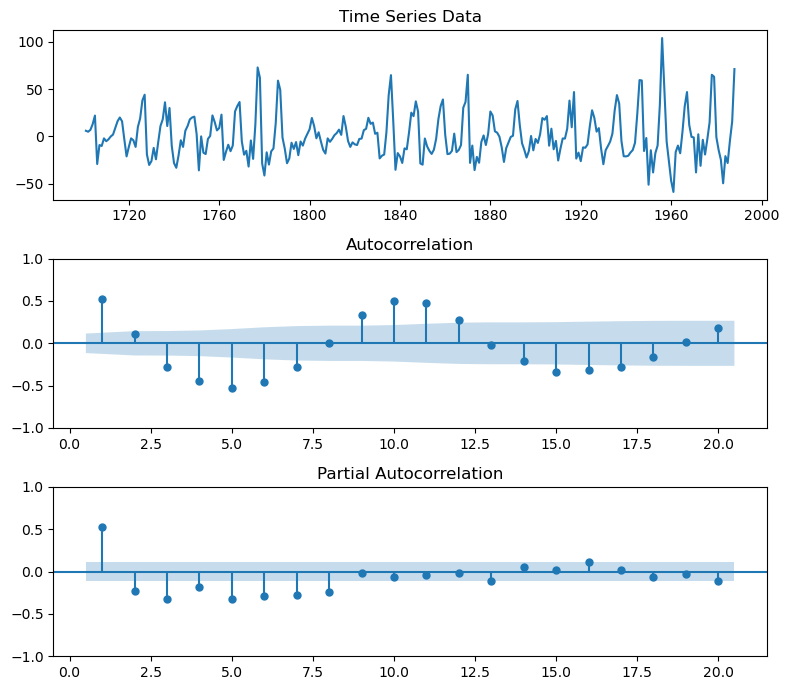

ADF Statistic: -14.076
ADF p-value: 0.000
p-value < 0.05: the series is stationary
--------------------------------
KPSS Statistic: 0.008
KPSS p-value: 0.100
p-value > 0.05: the series is stationary


In [ ]:
data_diff = ts_data.diff().dropna()
plot_data_acf_pacf(data_diff, lags=20)
test_stationarity(data_diff)

#### Modeling ARIMA
- Select the orders of p & q by the ACF PACF

##### Fit Model & Evaluate

train shape: (260, 1)
test shape: (28, 1)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  260
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1072.548
Date:                Mon, 29 Sep 2025   AIC                           2161.096
Time:                        10:39:58   BIC                           2189.581
Sample:                    01-01-1701   HQIC                          2172.547
                         - 01-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3160      0.482      0.656      0.512      -0.628       1.260
ar.L1          1.7160      0.506      3.392      0.001       0.724       2.708
ar.L2     

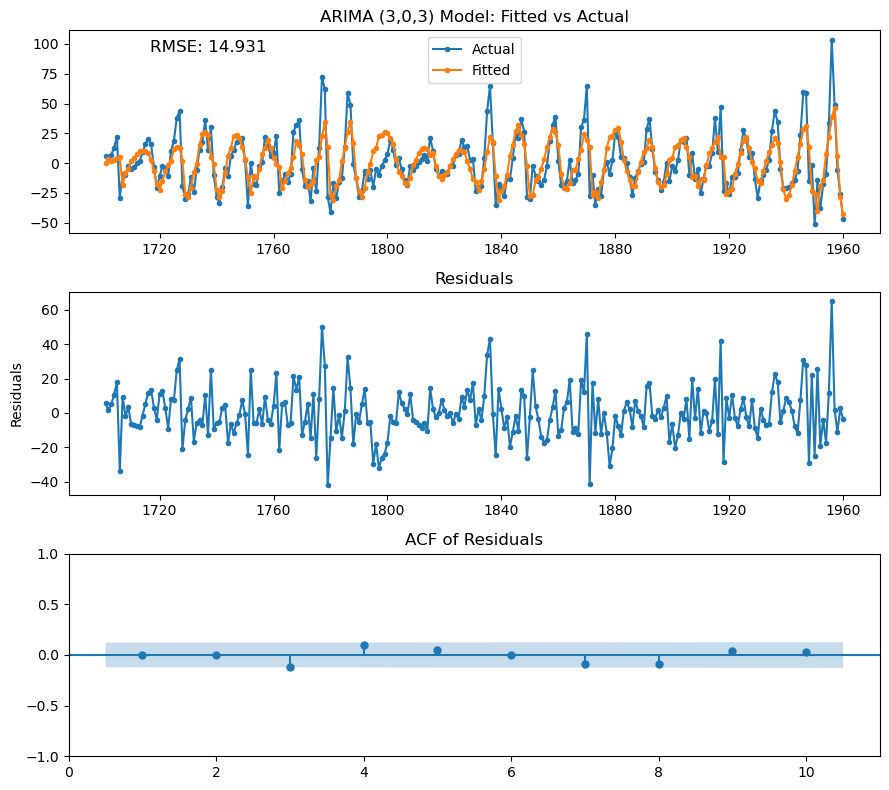

In [ ]:
# split the data into train and test, with last 30 months as test set
train, test , test_size = split_data(data_diff, test_prop=0.1)

p = 3 # AR order
d = 0 # Differencing order
q = 3 # MA order

# fit the model to the train data
model = ARIMA(train,order = (p,d,q)).fit()

print(model.summary())

evaluate_arima_model(model, train, lags=10)


##### Predict Multistep Future Valvues

ARIMA RMSE: 24.76


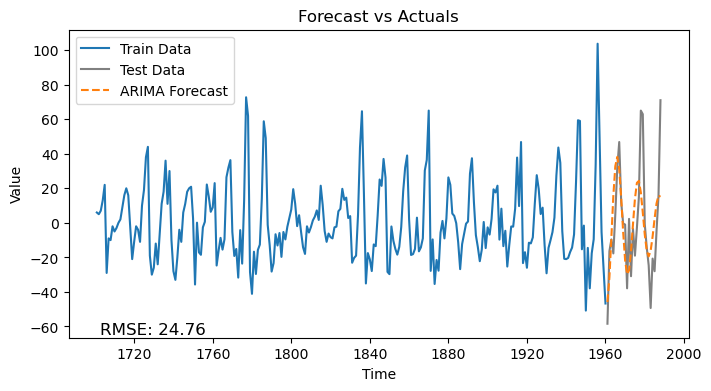

In [ ]:
# Forecast the test data
forecast = model.forecast(steps=test_size)
plot_forecast_vs_actuals(train, test, forecast)


### **Stock price AAPL data**

#### Explore Time Series data 

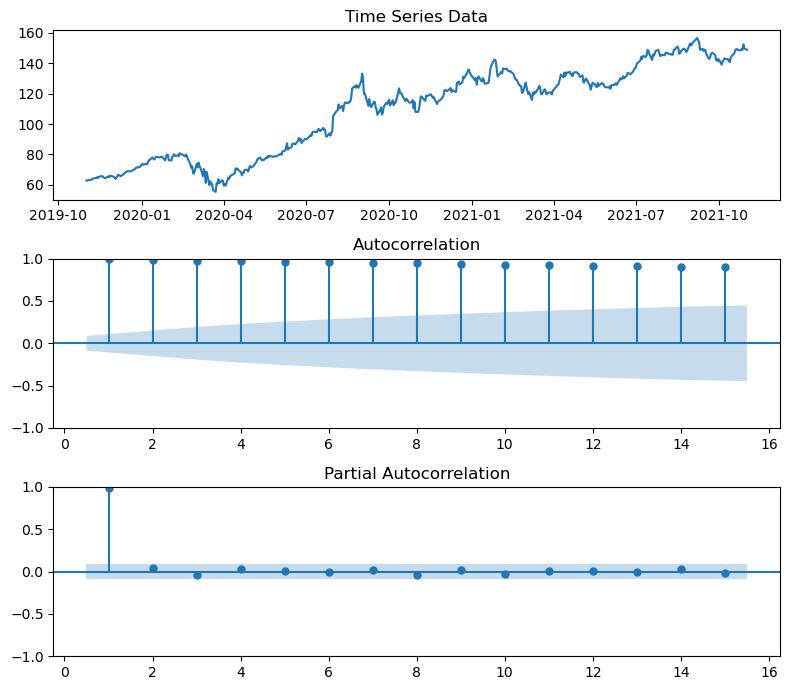

ADF Statistic: -1.007
ADF p-value: 0.751
p-value > 0.05: the series is non-stationary
--------------------------------
KPSS Statistic: 3.417
KPSS p-value: 0.010
p-value < 0.05: the series is non-stationary


In [68]:
## Select the Data
ts_data = closing_price['AAPL']

plot_data_acf_pacf(ts_data, lags=15)
test_stationarity(ts_data)

#### Differencing
- First order differencing removes trend 
- Use seasonal differencing if needed

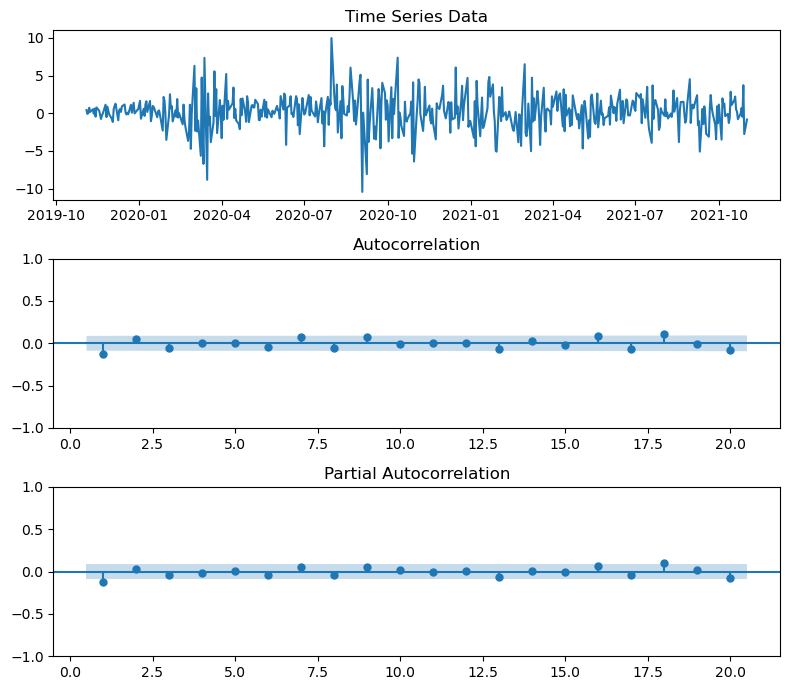

ADF Statistic: -25.383
ADF p-value: 0.000
p-value < 0.05: the series is stationary
--------------------------------
KPSS Statistic: 0.052
KPSS p-value: 0.100
p-value > 0.05: the series is stationary


In [69]:
data_diff = ts_data.diff().dropna()
plot_data_acf_pacf(data_diff, lags=20)
test_stationarity(data_diff)

#### Modeling ARIMA
- Select the orders of p & q by the ACF PACF

##### Fit Model & Evaluate

train shape: (454,)
test shape: (50,)
                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                  454
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1013.800
Date:                Mon, 29 Sep 2025   AIC                           2041.601
Time:                        10:48:19   BIC                           2070.412
Sample:                             0   HQIC                          2052.953
                                - 454                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8748      0.024    -35.834      0.000      -0.923      -0.827
ar.L2          0.8775      0.045     19.310      0.000       0.788       0.967
ar.L3         

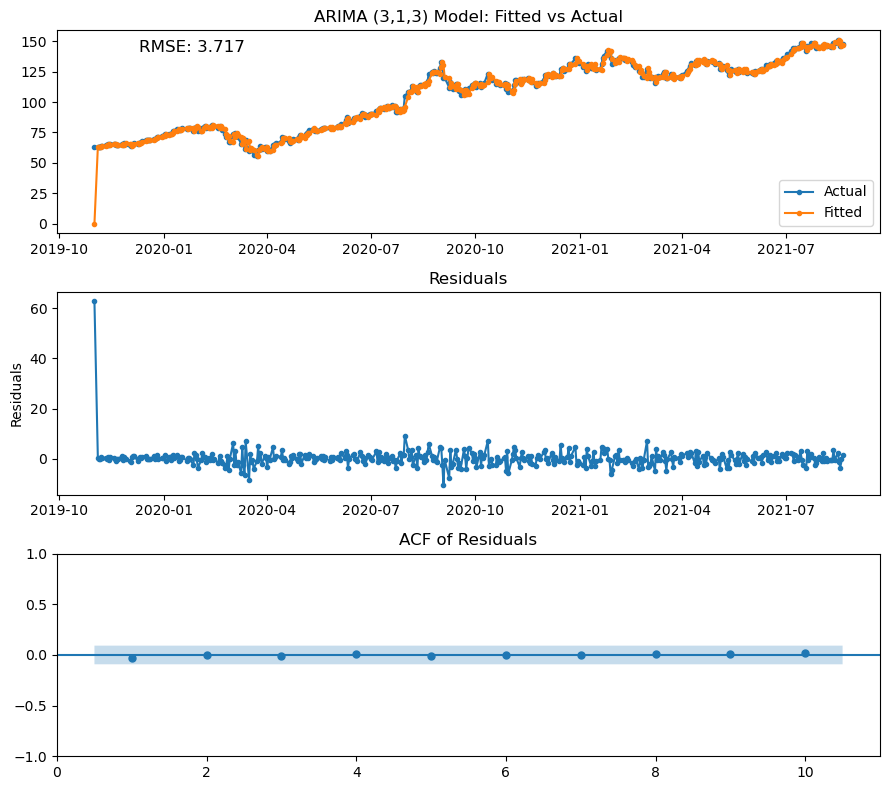

In [74]:
# split the data into train and test, with last 30 months as test set
train, test , test_size = split_data(ts_data, test_prop=0.1)

p = 3 # AR order
d = 1 # Differencing order
q = 3 # MA order

# fit the model to the train data
model = ARIMA(train,order = (p,d,q)).fit()

print(model.summary())

evaluate_arima_model(model, train, lags=10)


##### Predict Multistep Future Valvues

ARIMA RMSE: 5.62


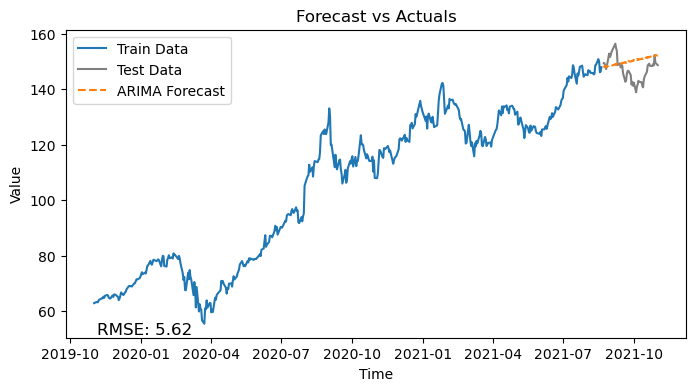

In [75]:
# Forecast the test data
forecast = model.forecast(steps=test_size)
plot_forecast_vs_actuals(train, test, forecast)


### **Air Passengers Data**

#### Explore Time Series data 

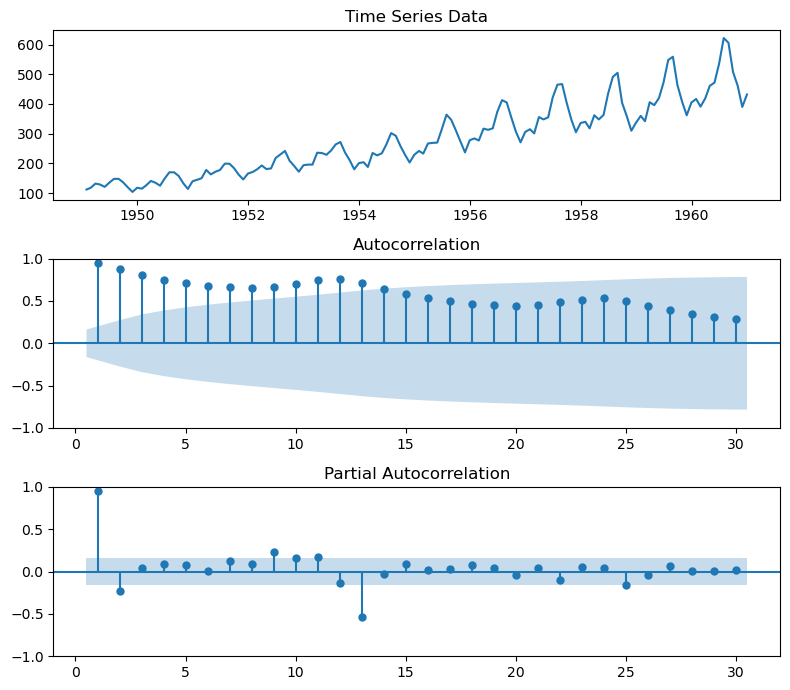

ADF Statistic: 0.815
ADF p-value: 0.992
p-value > 0.05: the series is non-stationary
--------------------------------
KPSS Statistic: 1.651
KPSS p-value: 0.010
p-value < 0.05: the series is non-stationary


In [77]:
## Select the Data
ts_data = airp_df

plot_data_acf_pacf(ts_data, lags=30)
test_stationarity(ts_data)

#### Differencing 
- First order differencing removes trend 
- Use seasonal differencing if needed

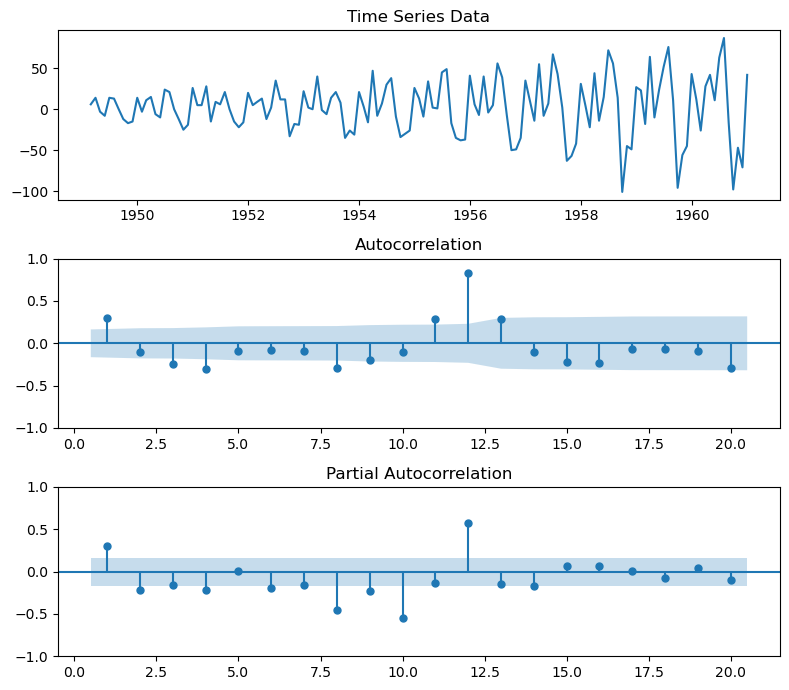

ADF Statistic: -2.829
ADF p-value: 0.054
p-value > 0.05: the series is non-stationary
--------------------------------
KPSS Statistic: 0.024
KPSS p-value: 0.100
p-value > 0.05: the series is stationary


In [86]:
data_diff = ts_data.diff().dropna()
plot_data_acf_pacf(data_diff, lags=20)
test_stationarity(data_diff)

ADF Statistic: -15.596
ADF p-value: 0.000
p-value < 0.05: the series is stationary
--------------------------------
KPSS Statistic: 0.047
KPSS p-value: 0.100
p-value > 0.05: the series is stationary


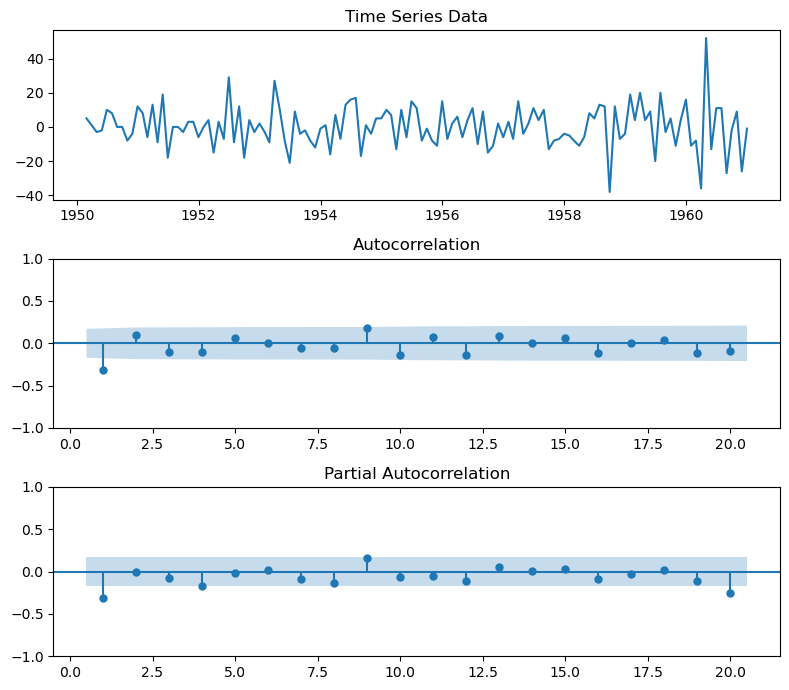

In [87]:
# Apply seasonal differencing based on known seasonality
data_deseason = data_diff.diff(12).dropna() # Seasonal differencing with period 12 months
test_stationarity(data_deseason)
plot_data_acf_pacf(data_deseason, lags=20)

#### Modeling ARIMA
- Select the orders of p & q by the ACF PACF

#### Fit Model & Evaluate

train shape: (118, 1)
test shape: (13, 1)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  118
Model:                 ARIMA(2, 0, 4)   Log Likelihood                -437.301
Date:                Mon, 29 Sep 2025   AIC                            890.602
Time:                        11:03:44   BIC                            912.768
Sample:                    02-28-1950   HQIC                           899.602
                         - 11-30-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3880      0.543      0.714      0.475      -0.677       1.453
ar.L1         -0.7437      0.279     -2.670      0.008      -1.290      -0.198
ar.L2     

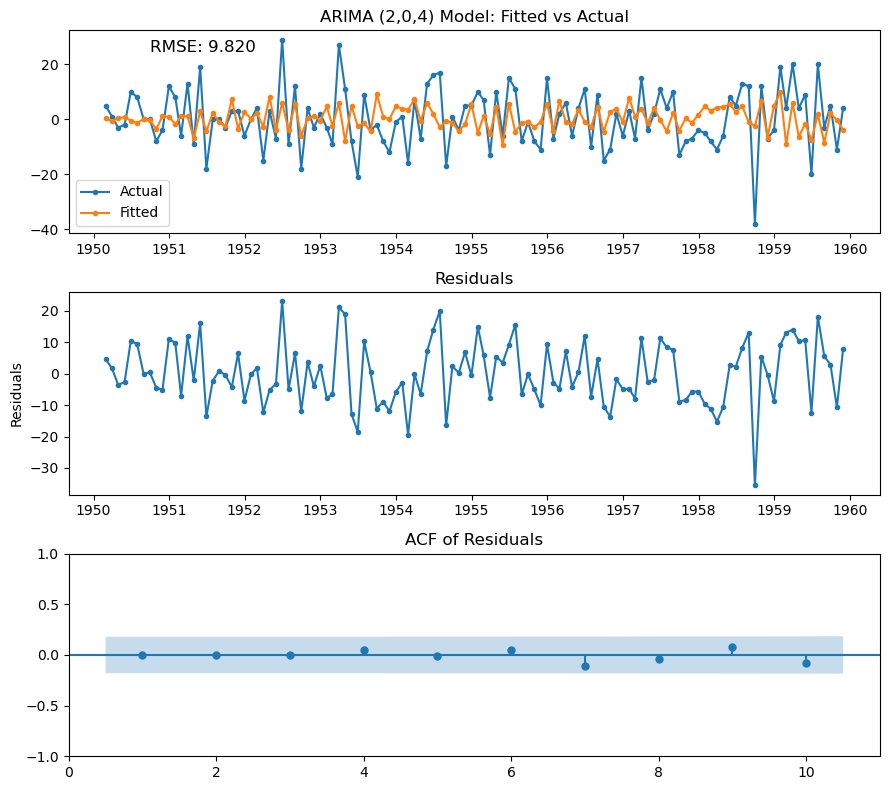

In [98]:
# split the data into train and test, with last 30 months as test set
train, test , test_size = split_data(data_deseason, test_prop=0.1)

p = 2 # AR order
d = 0 # Differencing order
q = 4 # MA order

# fit the model to the train data
model = ARIMA(train,order = (p,d,q)).fit()

print(model.summary())

evaluate_arima_model(model, train, lags=10)


##### Predict Multistep Future Valvues

ARIMA RMSE: 32.44


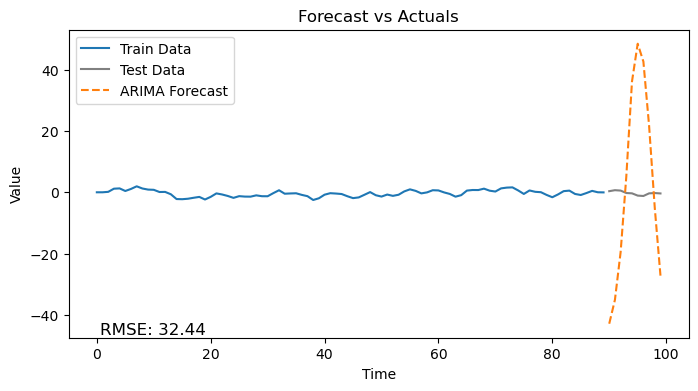

AttributeError: 'function' object has no attribute 'index'

In [97]:
# Forecast the test data
forecast = model_fit.forecast(steps=test_size)
plot_forecast_vs_actuals(train, test, forecast)
evaluate_arima_model(model, train, lags=10)

#### Apply SARIMA to the original scale 

train shape: (130, 1)
test shape: (14, 1)
                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  130
Model:             ARIMA(2, 0, 2)x(1, 1, [1], 12)   Log Likelihood                -440.903
Date:                            Mon, 29 Sep 2025   AIC                            895.805
Time:                                    10:56:00   BIC                            915.200
Sample:                                01-31-1949   HQIC                           903.680
                                     - 10-31-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4240      0.424      0.999      0.318      -0.408      

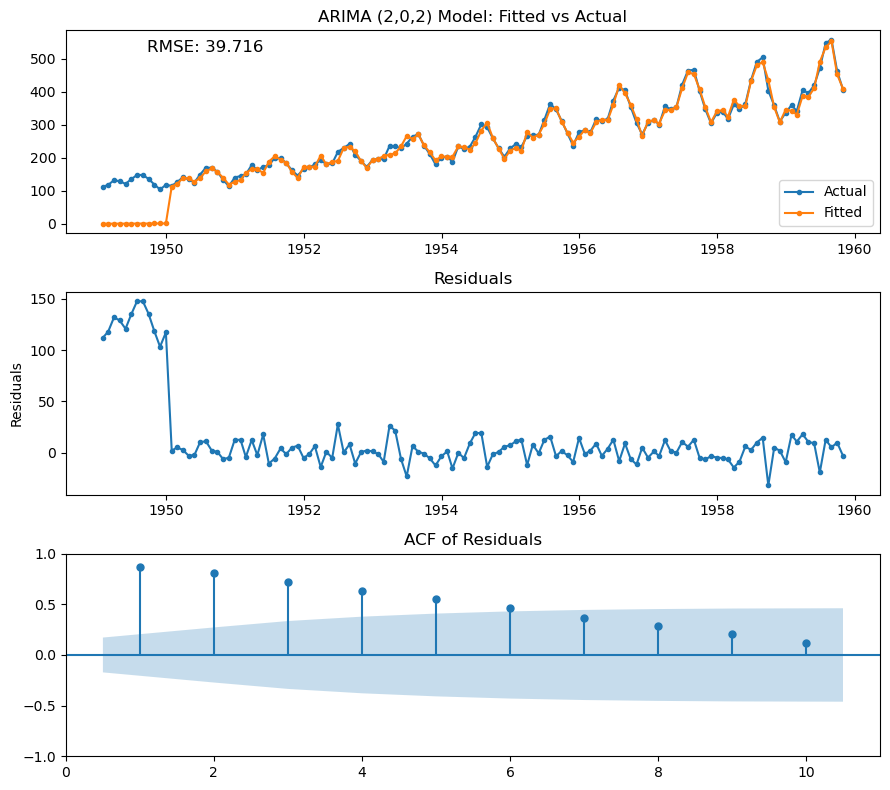

In [93]:
# split the data into train and test, with last 30 months as test set
train, test , test_size = split_data(ts_data, test_prop=0.1)

p = 2 # AR order
d = 0 # Differencing order
q = 2 # MA order

P = 1 # Seasonal AR order
D = 1 # Seasonal Differencing order
Q = 1 # Seasonal MA order

# fit the model to the train data
model = ARIMA(train,order = (p,d,q), seasonal_order=(P,D,Q,12)).fit()

print(model.summary())

evaluate_arima_model(model, train, lags=10)



##### Predict Multistep Future Valvues

ARIMA RMSE: 475.53


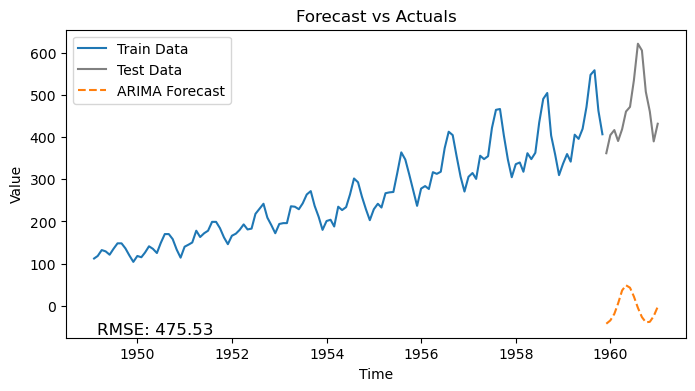

In [94]:
# Forecast the test data
forecast = model_fit.forecast(steps=test_size)
plot_forecast_vs_actuals(train, test, forecast)

## **Auto ARIMA**
- find optimal parameters using built in function

In [141]:
from pmdarima import auto_arima

def evaluate_auto_arima_model(model, train, lags=20):
    """
    Evaluate Auto ARIMA model fit on training data.
    Plots: Fitted vs Actual, Residuals, and ACF of Residuals.
    Prints RMSE.

    Parameters:
    - model: fitted pmdarima auto_arima model
    - train: pandas Series/DataFrame of training data
    - lags: number of lags for ACF plot
    """
    # Get in-sample fitted values and align with train index
    fitted_vals = model.predict_in_sample()
    fitted_vals = pd.Series(fitted_vals, index=train.index)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(train, fitted_vals))
    print(f"RMSE: {rmse:.3f}")

    # Calculate residuals
    residuals = train.sub(fitted_vals, axis='index').squeeze()
    p, d, q = model.order

    fig, axes = plt.subplots(3, 1, figsize=(9, 8))

    # Plot fitted vs actual
    axes[0].plot(train.index, train, label='Actual', marker='.')
    axes[0].plot(train.index, fitted_vals, label='Fitted', marker='.')
    axes[0].text(0.01, 0.1, f'RMSE: {rmse:.3f}', transform=axes[0].transAxes, fontsize=12, ha='left', va='top')
    axes[0].set_title(f'Auto ARIMA ({p},{d},{q}) Model: Fitted vs Actual')
    axes[0].legend()

    # Plot residuals
    axes[1].plot(train.index, residuals, marker='.')
    axes[1].set_title('Residuals')
    axes[1].set_ylabel('Residuals')

    # Ensure residuals is 1D numpy array for ACF plot
    residuals_1d = np.asarray(residuals).flatten()
    plot_acf(residuals_1d, lags=lags, zero=False, ax=axes[2])
    axes[2].set_title('ACF of Residuals')

    plt.tight_layout()
    plt.show()

### **ARMA simulated Data**

train shape: (90, 1)
test shape: (10, 1)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=162.721, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=271.248, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=181.498, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=184.437, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=160.782, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=174.872, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=166.226, Time=0.01 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=162.736, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=166.383, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=161.716, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=164.730, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=161.816, Time=0.03 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 0.325 seconds
best params:
{'maxiter': 50, 'method': 'lbfgs', 'order': (1

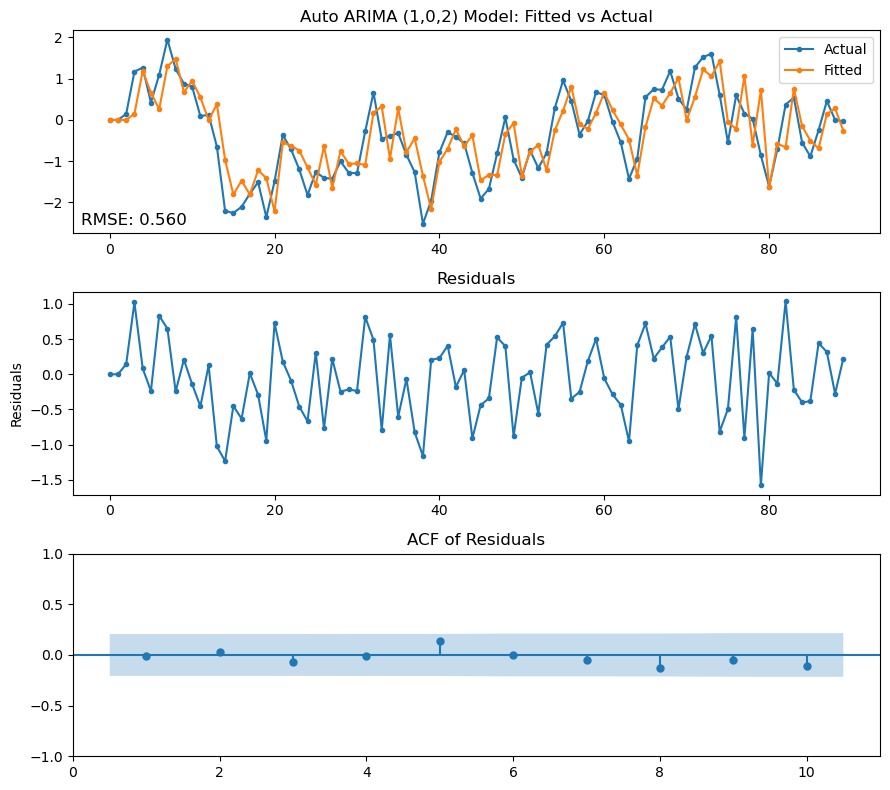

ARIMA RMSE: 0.63


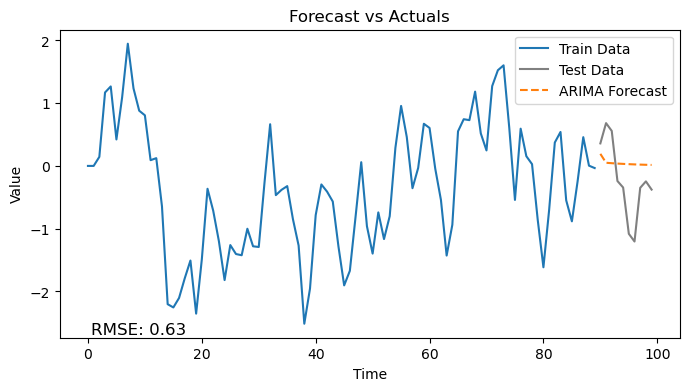

In [142]:
# train test split
train, test, test_size = split_data(arima, test_prop=0.1)

model = auto_arima(train, 
                   seasonal=False, 
                   stepwise=True,
                   suppress_warnings=True,
                   trace=True) # set trace to True to print the steps


# print the parameters of the best model params and fit the model with the best params
print('best params:')   
print(model.get_params())

model.fit(train)

# Forecast the test data
evaluate_auto_arima_model(model, train, lags=10)
forecast = model.predict(n_periods=test_size)
plot_forecast_vs_actuals(train, test, forecast)

### **Sunspot Data**

train shape: (261, 1)
test shape: (28, 1)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2251.546, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2885.903, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2367.711, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2606.221, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2252.825, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2259.337, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2174.595, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2198.061, Time=0.08 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2193.121, Time=0.17 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2255.514, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2253.430, Time=0.05 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2188.599, Time=0.08 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2196.548, Time=0.12 

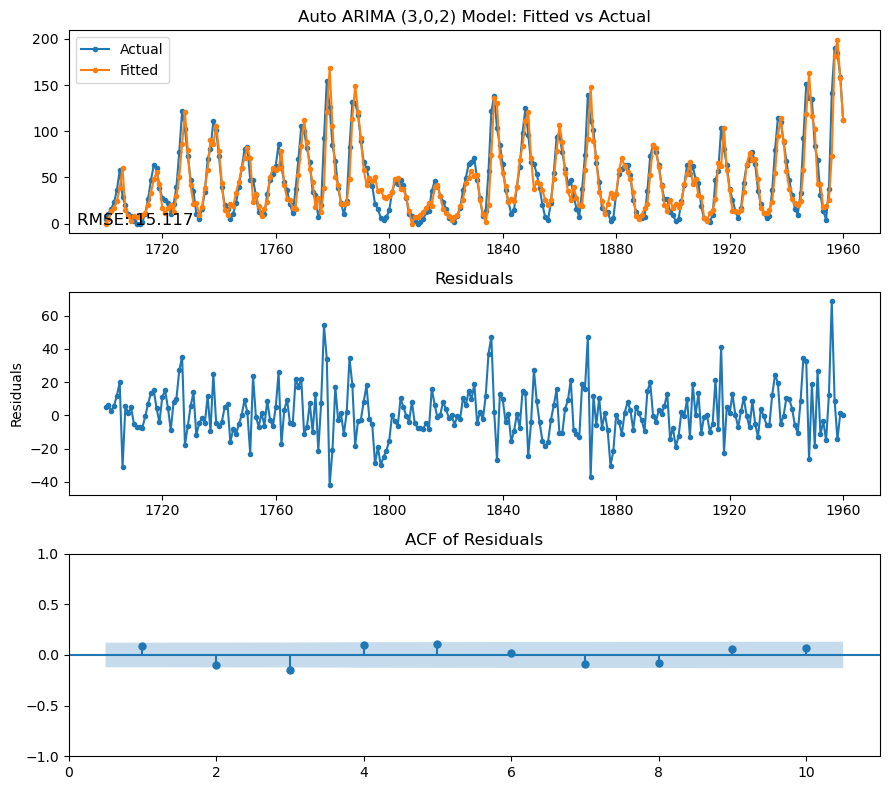

ARIMA RMSE: 38.54


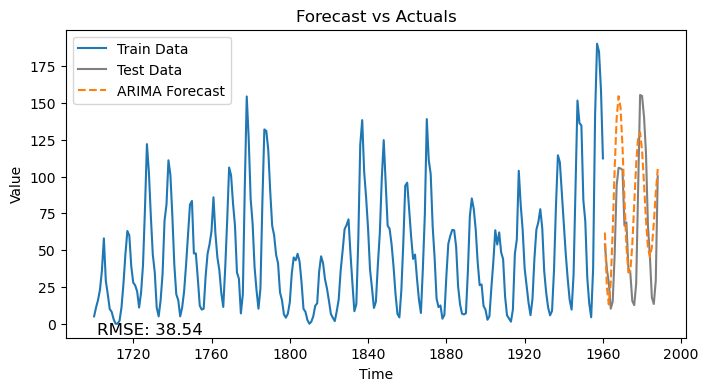

In [143]:
ts_data = sunspot_data
# train test split
train, test, test_size = split_data(ts_data, test_prop=0.1)

model = auto_arima(train, 
                   seasonal=False, 
                   stepwise=True,
                   suppress_warnings=True,
                   trace=True) # set trace to True to print the steps


# print the parameters of the best model params and fit the model with the best params
print('best params:')   
print(model.get_params())

model.fit(train)

# Forecast the test data
evaluate_auto_arima_model(model, train, lags=10)
forecast = model.predict(n_periods=test_size)
plot_forecast_vs_actuals(train, test, forecast)

### **Stock price AAPL data**

train shape: (454,)
test shape: (50,)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2046.538, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2047.675, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2041.147, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2041.658, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2048.667, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2042.829, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2042.717, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2044.704, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2043.038, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.314 seconds
best params:
{'maxiter': 50, 'method': 'lbfgs', 'order': (1, 1, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': Tru

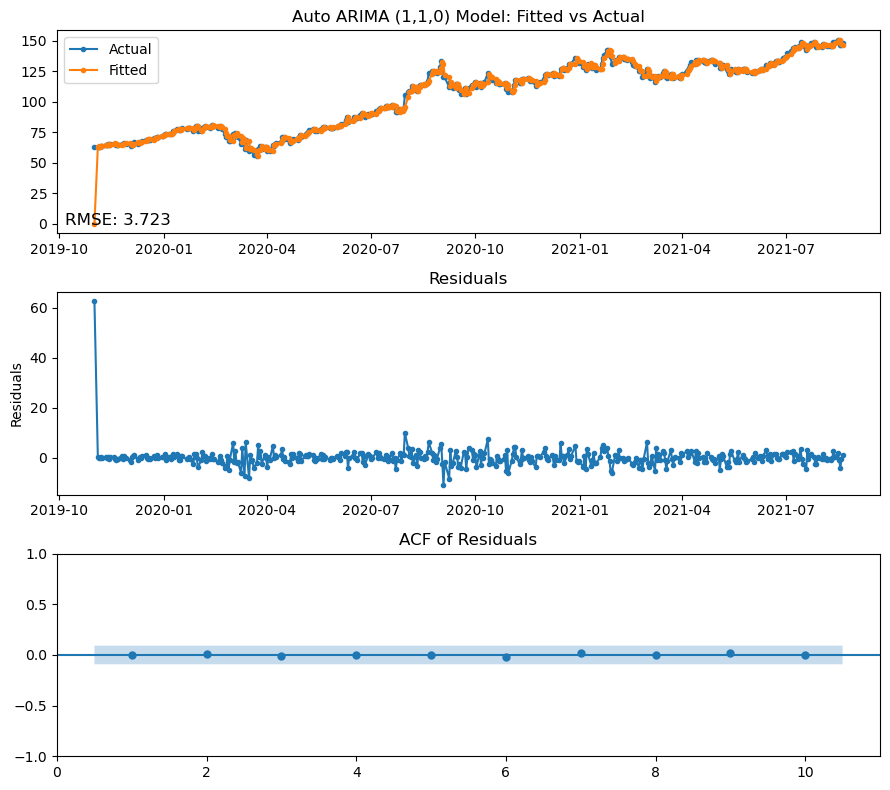

ARIMA RMSE: 7.89


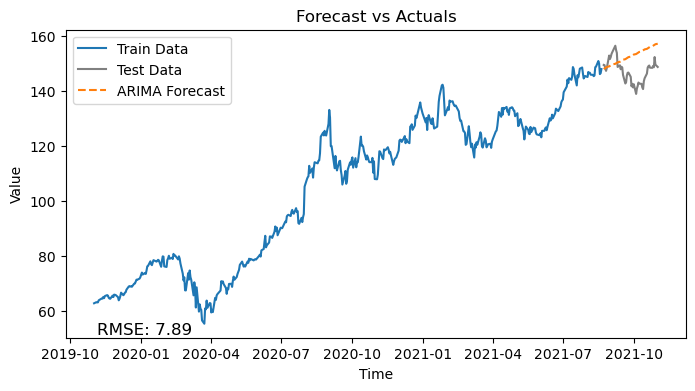

In [144]:
ts_data = closing_price['AAPL']
# train test split
train, test, test_size = split_data(ts_data, test_prop=0.1)

model = auto_arima(train, 
                   seasonal=False, 
                   stepwise=True,
                   suppress_warnings=True,
                   trace=True) # set trace to True to print the steps


# print the parameters of the best model params and fit the model with the best params
print('best params:')   
print(model.get_params())

model.fit(train)

# Forecast the test data
evaluate_auto_arima_model(model, train, lags=10)
forecast = model.predict(n_periods=test_size)
plot_forecast_vs_actuals(train, test, forecast)

### **Air Passengers Data**

train shape: (130, 1)
test shape: (14, 1)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1198.723, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1256.144, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1246.679, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1242.232, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1254.843, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1235.466, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,1,2)(0,0,

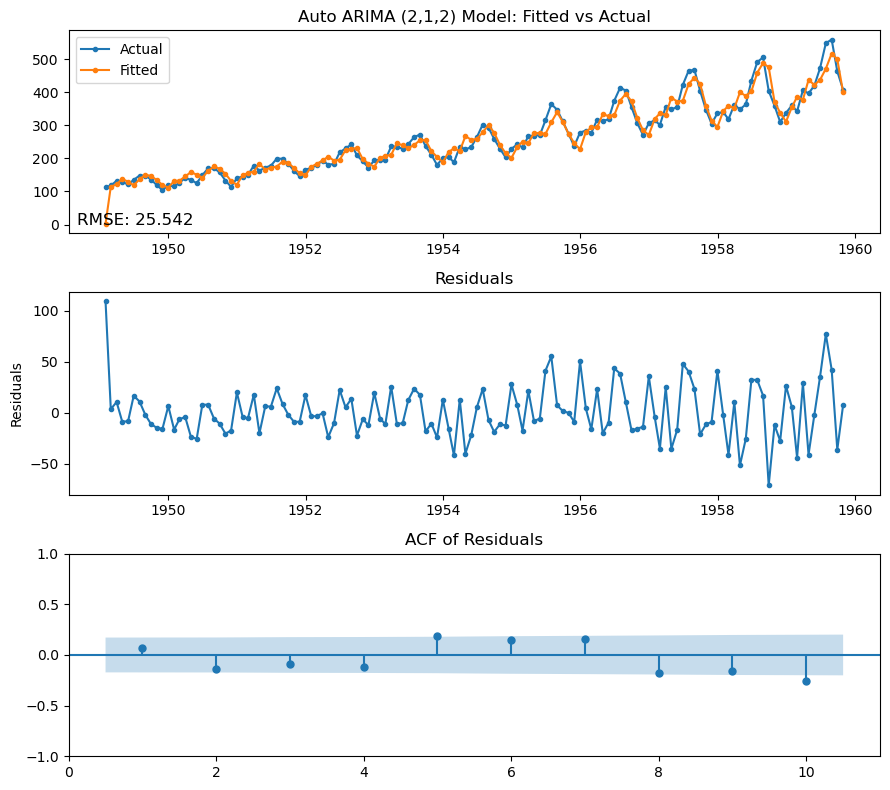

ARIMA RMSE: 50.88


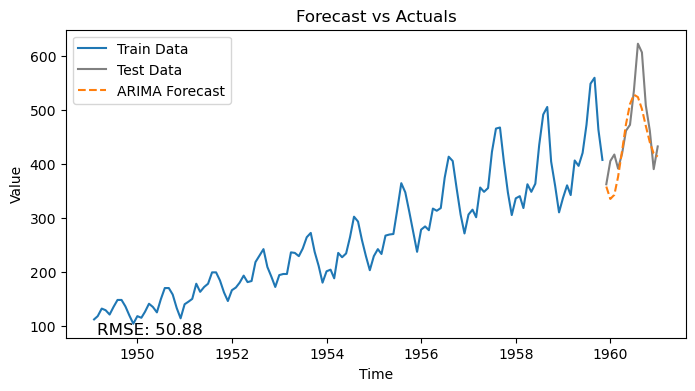

In [147]:
ts_data = airp_df
# train test split
train, test, test_size = split_data(ts_data, test_prop=0.1)

model = auto_arima(train, 
                   seasonal=True, 
                   stepwise=True,
                   suppress_warnings=True,
                   trace=True) # set trace to True to print the steps


# print the parameters of the best model params and fit the model with the best params
print('best params:')   
print(model.get_params())

model.fit(train)

# Forecast the test data
evaluate_auto_arima_model(model, train, lags=10)
forecast = model.predict(n_periods=test_size)
plot_forecast_vs_actuals(train, test, forecast)